In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
import btk
from galcheat.utilities import mean_sky_level
import matplotlib.pyplot as plt
import numpy as np

from btk.measure import get_snr
import torch

## BTK dataset

In [ ]:
max_n_sources = 1
min_n_sources = 1 # always once source
stamp_size =  53 * 0.2 # arcsecs
max_shift = 0.0 # shift from center (so centered)
seed = 0

catalog = btk.catalog.CatsimCatalog.from_file('../../../data/OneDegSq.fits')
catalog.get_raw_catalog()['i_ab'].min(), catalog.get_raw_catalog()['i_ab'].max()

(14.3246593475, 29.9895343781)

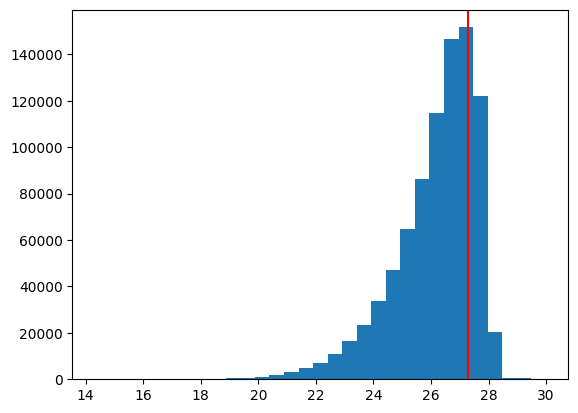

In [ ]:
cat = catalog.get_raw_catalog()
plt.hist(cat['i_ab'], bins=31)
plt.axvline(27.3, color='r')

In [ ]:
ra = cat['ra']
ra = (ra + ra.mean()) % 360
ra.max() - ra.min()

0.9999989267439844

In [ ]:
len(cat[cat['i_ab'] < 27.3]) / (3600) # 1 sq deg

185.13194444444446

In [ ]:
sampling_function = btk.sampling_functions.DefaultSampling(
    max_number=max_n_sources,
    min_number=min_n_sources,
    stamp_size=stamp_size, 
    max_shift=max_shift, 
    min_mag = 0,  # min mag in i-band is 14.32
    max_mag = 27.3, # see document for high level responses 
    seed = seed)


In [ ]:
LSST = btk.survey.get_surveys('LSST')
i_filt = LSST.get_filter('i')

In [ ]:
# get sky level in e- counts 
sky_level = mean_sky_level('LSST', 'i').to_value('electron')

In [ ]:
i_filt.psf_fwhm

<Quantity 0.79 arcsec>

In [ ]:

batch_size = 100

draw_generator = btk.draw_blends.CatsimGenerator(
    catalog,
    sampling_function,
    LSST,
    batch_size=batch_size,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="all",
    seed=seed, # use same seed here
)


In [ ]:
batch = next(draw_generator)
batch

BlendBatch(survey_name=LSST, 
	 blend_images: np.ndarray, shape [100, 6, 53, 53]
	 isolated_images: np.ndarray, shape [100, 1, 6, 53, 53]
	 catalog_list: list of <class 'astropy.table.table.Table'>, size 100
	 psfs: list of <class 'galsim.gsobject.GSObject'>, size 6
	 wcs: <class 'astropy.wcs.wcs.WCS'>)

In [ ]:
for p in batch.catalog_list[0].columns:
    print(p)

galtileid
ra
dec
redshift
fluxnorm_bulge
fluxnorm_disk
fluxnorm_agn
a_b
a_d
b_b
b_d
pa_bulge
pa_disk
u_ab
g_ab
r_ab
i_ab
z_ab
y_ab
x_peak
y_peak
btk_rotation
not_drawn_u
not_drawn_g
not_drawn_r
not_drawn_i
not_drawn_z
not_drawn_y


In [ ]:
d = dict(batch.catalog_list[0])
for p in d:
    print(d[p].value)

[402705367267]
[0.]
[0.]
[0.31423011]
[0.]
[2.17991994e-18]
[0.]
[0.]
[0.92527241]
[0.]
[0.62053549]
[0.]
[339.92495727]
[25.91155052]
[25.8383522]
[25.65806389]
[25.69213867]
[25.73265648]
[25.75240326]
[26.]
[26.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]
[0.]


In [ ]:
snrs = get_snr(batch.isolated_images[:, 0, 3], sky_level)

In [ ]:
a = np.array([1,2,3])
b = np.array([4,5,6])
np.vstack((a,b)).T

array([[1, 4],
       [2, 5],
       [3, 6]])

27.0603847504 3.0134590567345487


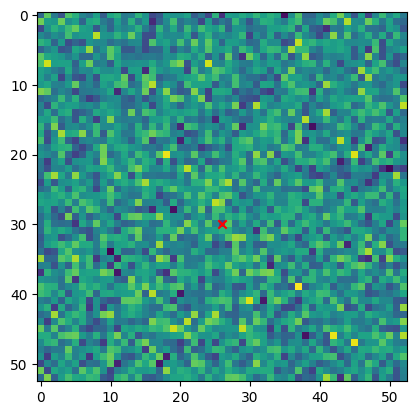

In [ ]:
idx = np.random.randint(0, 100)
plt.imshow(batch.blend_images[idx, 3]) # i-band, is indx = 3
plt.scatter(26, 30, color='r', marker='x')
print(batch.catalog_list[idx]['i_ab'].value.item(), snrs[idx])

(array([4.00000e+00, 7.00000e+00, 1.30000e+01, 1.90000e+01, 5.70000e+01,
        1.17000e+02, 2.06000e+02, 4.18000e+02, 8.79000e+02, 1.59600e+03,
        2.98700e+03, 5.26700e+03, 9.14900e+03, 1.50610e+04, 2.41320e+04,
        3.79030e+04, 5.75850e+04, 8.56110e+04, 1.21414e+05, 1.69334e+05,
        1.89156e+05, 1.30416e+05, 6.35000e+03, 4.45000e+02, 3.76000e+02]),
 array([14.32465935, 14.95125435, 15.57784935, 16.20444435, 16.83103935,
        17.45763435, 18.08422935, 18.71082436, 19.33741936, 19.96401436,
        20.59060936, 21.21720436, 21.84379936, 22.47039436, 23.09698936,
        23.72358437, 24.35017937, 24.97677437, 25.60336937, 26.22996437,
        26.85655937, 27.48315437, 28.10974937, 28.73634438, 29.36293938,
        29.98953438]),
 <BarContainer object of 25 artists>)

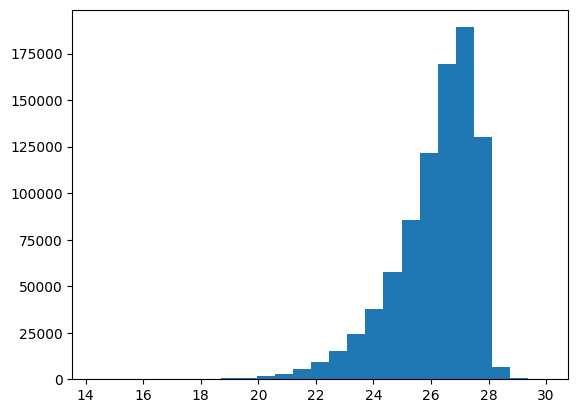

In [ ]:
plt.hist(catalog.get_raw_catalog()['i_ab'], bins=25)

In [ ]:
batch.catalog_list[0]['i_ab'].value.item()

24.3130187988

## stars

In [ ]:
from astropy.table import Table

star_data = "../../../data/stars_med_june2018.fits"
stars = Table.read(star_data)

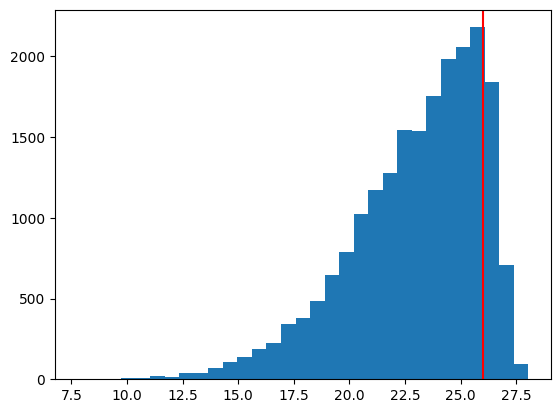

In [ ]:
plt.hist(stars['i_ab'], bins=31)
plt.axvline(26.0, color='r')

## Poisson distribution

In [ ]:
import numpy as np 
import scipy.special
import matplotlib.pyplot as plt

density = 185 
exp_count = 30
x = np.arange(0, 30)
px = (exp_count ** x) * np.exp(-exp_count) / scipy.special.factorial(x)

In [ ]:
scipy.special.factorial(x)

array([1.00000000e+00, 1.00000000e+00, 2.00000000e+00, 6.00000000e+00,
       2.40000000e+01, 1.20000000e+02, 7.20000000e+02, 5.04000000e+03,
       4.03200000e+04, 3.62880000e+05, 3.62880000e+06, 3.99168000e+07,
       4.79001600e+08, 6.22702080e+09, 8.71782912e+10, 1.30767437e+12,
       2.09227899e+13, 3.55687428e+14, 6.40237371e+15, 1.21645100e+17,
       2.43290201e+18, 5.10909422e+19, 1.12400073e+21, 2.58520167e+22,
       6.20448402e+23, 1.55112100e+25, 4.03291461e+26, 1.08888695e+28,
       3.04888345e+29, 8.84176199e+30])

In [ ]:
np.random.poisson(exp_count)

34

# test new BLISS datasets

## Single galaxies

In [ ]:
from bliss.datasets.single_galaxies import SingleGalsimGalaxies

single_dataset = SingleGalsimGalaxies(catalog_file='../../../data/OneDegSq.fits', slen=88, seed=0)

In [ ]:
batch['params']

{'galtileid': tensor([402702727452]),
 'ra': tensor([0.]),
 'dec': tensor([0.]),
 'redshift': tensor([3.0691]),
 'fluxnorm_bulge': tensor([0.]),
 'fluxnorm_disk': tensor([3.0228e-18]),
 'fluxnorm_agn': tensor([0.]),
 'a_b': tensor([0.]),
 'a_d': tensor([0.3150]),
 'b_b': tensor([0.]),
 'b_d': tensor([0.1918]),
 'pa_bulge': tensor([0.]),
 'pa_disk': tensor([308.9677]),
 'u_ab': tensor([26.4468]),
 'g_ab': tensor([25.1747]),
 'r_ab': tensor([24.9127]),
 'i_ab': tensor([24.9602]),
 'z_ab': tensor([25.1006]),
 'y_ab': tensor([25.0884]),
 'x_peak': tensor([43.5000], dtype=torch.float64),
 'y_peak': tensor([43.5000], dtype=torch.float64),
 'btk_rotation': tensor([0.], dtype=torch.float64),
 'not_drawn_u': tensor([0.], dtype=torch.float64),
 'not_drawn_g': tensor([0.], dtype=torch.float64),
 'not_drawn_r': tensor([0.], dtype=torch.float64),
 'not_drawn_i': tensor([0.], dtype=torch.float64),
 'not_drawn_z': tensor([0.], dtype=torch.float64),
 'not_drawn_y': tensor([0.], dtype=torch.float64)}

 galtileid  
------------
402707889055 galtileid
 ra
---
0.0 ra
dec
---
0.0 dec
   redshift  
-------------
2.24137401581 redshift
 fluxnorm_bulge 
----------------
6.9704028678e-18 fluxnorm_bulge
  fluxnorm_disk  
-----------------
1.66535693699e-17 fluxnorm_disk
fluxnorm_agn
------------
         0.0 fluxnorm_agn
     a_b     
-------------
1.05356252193 a_b
     a_d     
-------------
1.29824328423 a_d
     b_b     
-------------
1.02388548851 b_b
     b_d     
-------------
0.41492420435 b_d
   pa_bulge  
-------------
310.696014404 pa_bulge
   pa_disk   
-------------
310.696014404 pa_disk
     u_ab    
-------------
30.5375728607 u_ab
     g_ab    
-------------
28.1572227478 g_ab
     r_ab    
-------------
26.8970546722 r_ab
     i_ab    
-------------
26.3998508453 i_ab
     z_ab    
-------------
25.5874519348 z_ab
     y_ab    
-------------
24.7236404419 y_ab
x_peak
------
  43.5 x_peak
      y_peak     
-----------------
43.49999999993685 y_peak
btk_rotation
------------
 

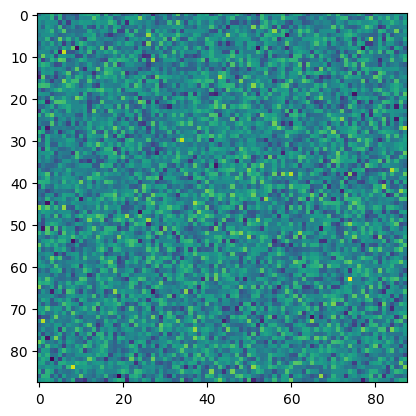

In [ ]:
batch = single_dataset[0]
plt.imshow(batch['images'][0])
print(batch['snr'])

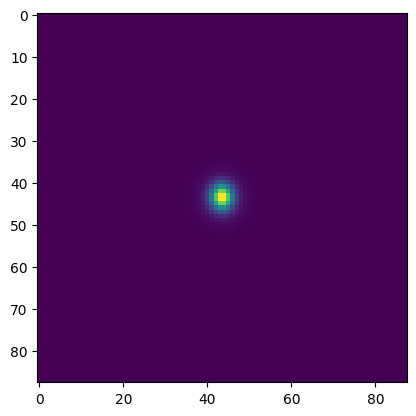

In [ ]:
plt.imshow(batch['noiseless'][0])

In [ ]:
batch['params']

{'galtileid': tensor([402700538259]),
 'ra': tensor([0.]),
 'dec': tensor([0.]),
 'redshift': tensor([0.4687]),
 'fluxnorm_bulge': tensor([1.1689e-17]),
 'fluxnorm_disk': tensor([4.8684e-17]),
 'fluxnorm_agn': tensor([0.]),
 'a_b': tensor([0.4347]),
 'a_d': tensor([0.2333]),
 'b_b': tensor([0.4260]),
 'b_d': tensor([0.0539]),
 'pa_bulge': tensor([267.8273]),
 'pa_disk': tensor([267.8273]),
 'u_ab': tensor([25.0771]),
 'g_ab': tensor([24.2188]),
 'r_ab': tensor([23.1173]),
 'i_ab': tensor([22.5682]),
 'z_ab': tensor([22.2310]),
 'y_ab': tensor([22.0364]),
 'x_peak': tensor([43.5000], dtype=torch.float64),
 'y_peak': tensor([43.5000], dtype=torch.float64),
 'btk_rotation': tensor([0.], dtype=torch.float64),
 'not_drawn_u': tensor([0.], dtype=torch.float64),
 'not_drawn_g': tensor([0.], dtype=torch.float64),
 'not_drawn_r': tensor([0.], dtype=torch.float64),
 'not_drawn_i': tensor([0.], dtype=torch.float64),
 'not_drawn_z': tensor([0.], dtype=torch.float64),
 'not_drawn_y': tensor([0.], d

## Blends

In [ ]:
from bliss.datasets.blends import GalsimBlends
from bliss.catalog import TileCatalog

In [ ]:
ds = GalsimBlends(catalog_file='../../../data/OneDegSq.fits', stars_file='../../../data/stars_med_june2018.fits', tile_slen=4, max_sources_per_tile=1, num_workers=1, batch_size=2, n_batches=1, bp=24, slen=40, seed=0)

In [ ]:
batch = ds[0]
tile_params = {k:v.unsqueeze(0) for k,v in batch.items() if k not in {'images', 'background'}}
tile_catalog = TileCatalog(4, tile_params) 
full_cat = tile_catalog.to_full_params()

batch['galaxy_bools'].sum(), batch['star_bools'].sum(), batch['star_bools']

torch.Size([8]) torch.Size([8, 1]) torch.Size([8, 1])


(tensor(2.), tensor(0.))

In [ ]:
# full_cat.keys()
# full_cat['star_bools'].shape, full_cat['galaxy_bools'].shape
# batch['star_bools'].shape, batch['star_fluxes'].shape, batch['galaxy_bools'].shape


In [ ]:
full_cat['mags'], full_cat.plocs + 24 -0.5

(tensor([[[22.2567],
          [26.1220]]]),
 tensor([[[23.8673, 27.4211],
          [62.6698, 51.5954]]]))

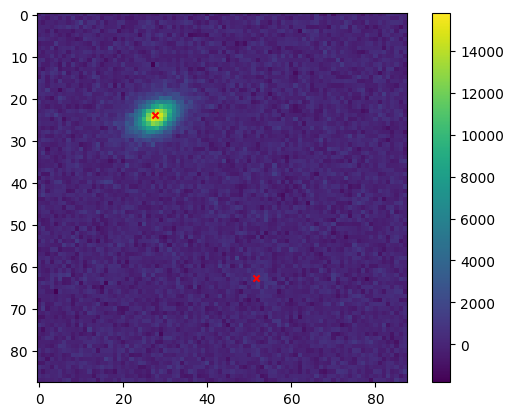

In [ ]:
bp = 24 


# print(batch['n_sources'].sum().item())

plt.imshow(batch['images'][0] - batch['background'][0])
plt.colorbar()

# need to make sure locs are correct


# x1 = tplocs[indx, :, 1] + bp - 0.5 - trim


x, y = full_cat.plocs[0, :,1] + 24 - 0.5, full_cat.plocs[0, :, 0] + 24 - 0.5

plt.scatter(x, y, marker="x", color="r", s=20)

In [ ]:
tile_params.keys()

dict_keys(['n_sources', 'locs', 'galaxy_bools', 'star_bools', 'star_fluxes', 'star_log_fluxes', 'galaxy_params', 'mags', 'ellips', 'snr', 'blendedness', 'fluxes'])

In [ ]:
batch['images'][0]

tensor([[183312.7531, 184034.1672, 183561.0552,  ..., 183548.6127,
         184127.8142, 183348.9175],
        [183471.6655, 183605.2105, 183485.8907,  ..., 183401.6336,
         183453.9241, 183371.3914],
        [184064.4842, 183859.4757, 183854.8985,  ..., 184115.1714,
         183225.6894, 184317.0490],
        ...,
        [183205.7351, 183682.0272, 183740.9838,  ..., 183633.1050,
         183190.3656, 183265.0289],
        [183892.0551, 183153.8765, 184209.4282,  ..., 184167.3542,
         183769.6804, 183028.3487],
        [184303.6548, 183594.7333, 183941.1743,  ..., 183036.5333,
         183227.9066, 183459.8060]], dtype=torch.float64)

In [ ]:
batch['fluxes'].squeeze()

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 1.1648e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         1.7071e+05, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000

In [ ]:
batch['n_sources']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### Playing with mags

In [ ]:
import galcheat

import astropy.units as u

In [ ]:
lsst=galcheat.get_survey('LSST')
i_band = lsst.get_filter('i')

In [ ]:
i_band.zeropoint

<Quantity 27.78 mag>

In [ ]:
u.mag(u.electron / u.s) * 24 

<Magnitude 24. mag(electron / s)>

In [ ]:
mag = 24 * u.mag(u.electron / u.s)
print(mag)

24.0 mag(electron / s)


In [ ]:
24 * u.electron / u.s

<Quantity 24. electron / s>

In [ ]:
24 * u.mag(u.electron / u.s)  - i_band.zeropoint

<Magnitude -3.78 mag(electron / s)>

In [ ]:
flux_s = 179448 * u.electron/ i_band.full_exposure_time
flux_s.to(u.mag(u.electron / u.s)) + i_band.zeropoint

<Magnitude 24.00000114 mag(electron / s)>

In [ ]:
import torch
from bliss.datasets.lsst import convert_mag_to_flux, convert_flux_to_mag
fluxes = convert_mag_to_flux(torch.tensor([24, 25]))
mags = convert_flux_to_mag(fluxes)
print(fluxes, mags)

tensor([179448,  71439]) tensor([24.0000, 25.0000], dtype=torch.float64)


## stackings dicts for easier io 

In [ ]:
import torch
d1 = {'a':torch.zeros(2,2), 'b':{'c':torch.zeros((2,3)), 'd':torch.ones((3,3))}}
d2 = {'a':torch.ones(2,2), 'b':{'c':torch.ones((2,3)), 'd':torch.zeros((3,3))}}

In [ ]:
d = {} 
from case_studies.galsim_galaxies.get_datasets import _stack_tensor_dict
d =_stack_tensor_dict(d, d1)
d = _stack_tensor_dict(d, d2)

In [ ]:
d['a'].shape, d['b']['c'].shape, d['b']['d'].shape

(torch.Size([2, 2, 2]), torch.Size([2, 2, 3]), torch.Size([2, 3, 3]))

In [ ]:
d['a'][1]

tensor([[1., 1.],
        [1., 1.]])

In [ ]:
d1['a']

tensor([[0., 0.],
        [0., 0.]])

## Look at saved blends datasets


In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
d1 = torch.load("../data/test_blends.pt")
d2 = torch.load("../data/val_blends.pt")

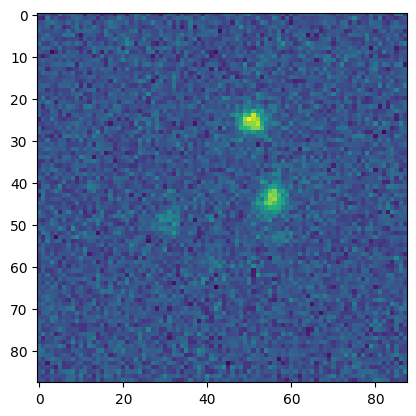

In [ ]:
plt.imshow(d1['images'][13, 0])

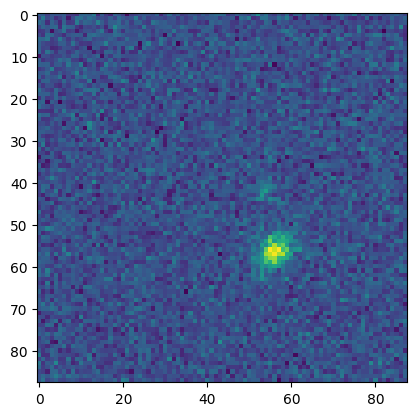

In [ ]:
plt.imshow(d2['images'][13, 0])

In [ ]:
d1['full_params']

TensorDict(
    fields={
        blendedness: Tensor(shape=torch.Size([100, 8, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        ellips: Tensor(shape=torch.Size([100, 8, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        fluxes: Tensor(shape=torch.Size([100, 8, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        galaxy_bools: Tensor(shape=torch.Size([100, 8, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        galaxy_params: Tensor(shape=torch.Size([100, 8, 10]), device=cpu, dtype=torch.float32, is_shared=False),
        mags: Tensor(shape=torch.Size([100, 8, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        n_sources: Tensor(shape=torch.Size([100]), device=cpu, dtype=torch.int64, is_shared=False),
        plocs: Tensor(shape=torch.Size([100, 8, 2]), device=cpu, dtype=torch.float32, is_shared=False),
        snr: Tensor(shape=torch.Size([100, 8, 1]), device=cpu, dtype=torch.float32, is_shared=False),
        star_bools: Te

In [ ]:
d1['tile_params']['fluxes'][13].squeeze()

tensor([[     0.,      0.,      0.,      0.,      0.,      0., 121623.,      0.,
              0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,  10920.],
        [     0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.,      0., 129308.,
              0.,      0.],
        [     0.,  39797.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.],
        [     0.,      0.,      0.,      0.,      0.,      0.,      0.,      0.,
          18615.,      0.],
        [     0.,      0.,      0.,      0.,  14504.,      0.,      0.,      0.,
              0.,      0.],
        [     0.,  

In [ ]:
d1['full_params']['n_sources'].shape, d1['tile_params']['n_sources'].shape, d1['images'].shape

(torch.Size([100]), torch.Size([100, 10, 10]), torch.Size([100, 1, 88, 88]))

In [ ]:
d1.keys()

_StringKeys({'background': tensor([[[[183653.4400, 183653.4400, 183653.4400,  ..., 183653.4400,
           183653.4400, 183653.4400],
          [183653.4400, 183653.4400, 183653.4400,  ..., 183653.4400,
           183653.4400, 183653.4400],
          [183653.4400, 183653.4400, 183653.4400,  ..., 183653.4400,
           183653.4400, 183653.4400],
          ...,
          [183653.4400, 183653.4400, 183653.4400,  ..., 183653.4400,
           183653.4400, 183653.4400],
          [183653.4400, 183653.4400, 183653.4400,  ..., 183653.4400,
           183653.4400, 183653.4400],
          [183653.4400, 183653.4400, 183653.4400,  ..., 183653.4400,
           183653.4400, 183653.4400]]],


        [[[183653.4400, 183653.4400, 183653.4400,  ..., 183653.4400,
           183653.4400, 183653.4400],
          [183653.4400, 183653.4400, 183653.4400,  ..., 183653.4400,
           183653.4400, 183653.4400],
          [183653.4400, 183653.4400, 183653.4400,  ..., 183653.4400,
           183653.4400, 18365

In [ ]:
ks = d1.keys()


AttributeError: '_StringKeys' object has no attribute 'names'

## Datasets and datamodules

In [ ]:
import torch
from bliss.datasets.single_galaxies import SavedSingleGalsimGalaxies
from bliss.datasets.saved import SavedDataModule

s1 = SavedSingleGalsimGalaxies("../data/train_single_galaxies.pt", 10000)
s2 = SavedSingleGalsimGalaxies("../data/val_single_galaxies.pt", 10000)

dm = SavedDataModule(s1, s2, batch_size=64)
dl = dm.train_dataloader()

In [ ]:
# for ii,b in enumerate(dl):
#     print(b['images'].shape, b['background'].shape)
#     print(ii)

In [ ]:
# plt.imshow(b['images'][4,0])

In [ ]:
import torch
from bliss.datasets.blends import SavedGalsimBlends
from bliss.datasets.saved import SavedDataModule

s1 = SavedGalsimBlends("../data/train_blends.pt", 10000)
s2 = SavedGalsimBlends("../data/val_blends.pt", 10000)

dm = SavedDataModule(s1, s2, batch_size=64)
dl = dm.train_dataloader()

In [ ]:
for ii,b in enumerate(dl):
    print(b['images'].shape, b['background'].shape, b['n_sources'].shape, b['locs'].shape)
    print(ii)

torch.Size([64, 1, 88, 88]) torch.Size([64, 1, 88, 88]) torch.Size([64, 10, 10]) torch.Size([64, 10, 10, 1, 2])
0
torch.Size([64, 1, 88, 88]) torch.Size([64, 1, 88, 88]) torch.Size([64, 10, 10]) torch.Size([64, 10, 10, 1, 2])
1
torch.Size([64, 1, 88, 88]) torch.Size([64, 1, 88, 88]) torch.Size([64, 10, 10]) torch.Size([64, 10, 10, 1, 2])
2
torch.Size([64, 1, 88, 88]) torch.Size([64, 1, 88, 88]) torch.Size([64, 10, 10]) torch.Size([64, 10, 10, 1, 2])
3
torch.Size([64, 1, 88, 88]) torch.Size([64, 1, 88, 88]) torch.Size([64, 10, 10]) torch.Size([64, 10, 10, 1, 2])
4
torch.Size([64, 1, 88, 88]) torch.Size([64, 1, 88, 88]) torch.Size([64, 10, 10]) torch.Size([64, 10, 10, 1, 2])
5
torch.Size([64, 1, 88, 88]) torch.Size([64, 1, 88, 88]) torch.Size([64, 10, 10]) torch.Size([64, 10, 10, 1, 2])
6
torch.Size([64, 1, 88, 88]) torch.Size([64, 1, 88, 88]) torch.Size([64, 10, 10]) torch.Size([64, 10, 10, 1, 2])
7
torch.Size([64, 1, 88, 88]) torch.Size([64, 1, 88, 88]) torch.Size([64, 10, 10]) torch.S

In [ ]:
# # d1 = torch.load('../data/train_blends.pt')

# d1.pop('full_params')
# for p in ("ellips", "blendedness", "snr", "fluxes", "mags", 'galaxy_params'):
#     d1["tile_params"].pop(p)
# tile_params = d1.pop('tile_params')
# for p in tile_params.keys():
#     d1[p] = tile_params[p]

In [ ]:
# for b in dl: 
#     print(b)
#     break